## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems, Ng Geok Teng

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [1]:
# import our required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import get_scorer_names
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.utils import resample

from yellowbrick.classifier import PrecisionRecallCurve


# import random
# import patsy
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import PolynomialFeatures
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN, SMOTETomek
# from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks
# from imblearn.ensemble import BalancedBaggingClassifier
# from imblearn.pipeline import Pipeline


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

---

## Step 2: Obtain the data.

### 2.1 Read in the data.

In [2]:
# Read in the data
ckd = pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
# Print the first 5 rows
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [4]:
# Print summary statistics
ckd.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [5]:
# Check column names
ckd.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [6]:
# Check shape of our dataframe
ckd.shape

(400, 25)

In [7]:
# Check for missing values
ckd.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [8]:
# Check for duplicates
ckd.duplicated().sum()

0

In [9]:
# Check for class imbalance
ckd['class'].value_counts(normalize=True)

class
ckd       0.625
notckd    0.375
Name: proportion, dtype: float64

### 2.2 Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

**Answer:**

- First, I checked the ckd class variable to see if there were imbalanced classes. There is a 38/62 split for our binary classes.
- Secondly, since we want to predict ckd, it might be helpful to compare each variable with ckd to see which variables appear to have predictive value with our target.
- Thirdly, it can be helpful to check the patterns of missingness. Are any variables missing extensively so that it will be problematic? Is there any missingness that is explained by the data dictionary? (i.e. tests not run due to certain thresholds being met?)
- Fourthly, we can also check out the distributions of each variable. Are there certain variables that overwhelmingly take on one value and thus might not be predictive? Lots of these variables have "blood" in the name. There might be some relationship among these features. If certain features are correlated, then I'll want to include interaction terms or I'll want to remove some of them when building my model.

Although these are interesting points to consider, in the absence of consultation with a subject matter expert, we can spray and pray, I'm just kidding. I mean that we can make an assumption that the creators of this study have background knowledge that these features are important for predicting ckd. If we go with that assumption, then every feature in the data dictionary should be included in our model to improve the model's performance for classification. I call this the 'trust, don't verify' method. But seriously, I'm not actually a doctor and I have lost some faith in my ability to discern usefulness of features from my own common sense after the 'disaster' with the personality questions and handedness lab. Anyway, we would normally like to perform EDA to get a better look at our data before we start throwing in features into our ML model.

---

## Step 3: Explore the data.

### 3.1 Missing Data
#### 3.1.1 How much of the data is missing from each column?

In [10]:
# Calculate the % of missing data for each column
ckd.isnull().mean() * 100

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

**Answer:** <br>

Some of the data is missing from every column except for class. In particular, rbc, wbcc, and rbcc are missing over 100 observations each. I'm particularly concerned about the categories that are missing over 15% of their data. This is problematic and should be addressed. Somebody please explain to me why people like to leave questions blank in a survey. These people are obviously not completionists. Just have the option 'I don't know how to answer this' and point a big arrow at that option for every question. Then instead of missing data, we can have IDK data.



#### 3.1.2 Suppose that I dropped every row that contained at least one missing value. 

(In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.


In [11]:
# Drop rows with NA values
ckd_copy = ckd.dropna()
print(ckd_copy.shape)
ckd_copy['class'].value_counts()


(158, 25)


class
notckd    115
ckd        43
Name: count, dtype: int64

In [12]:
# Compare with value counts if we don't drop any rows
ckd['class'].value_counts()

class
ckd       250
notckd    150
Name: count, dtype: int64

**Answer:** 

Only 158 rows would remain. We'd drop 242 of our 400 observations (over 60% of our data!) by dropping each row that contains any missing value.

One downside to a complete case analysis is that dropping rows with missing data can result in the loss of a significant amount of information even in data sets that contain a modest number of variables. If "NaN" possibly means something (i.e. this test was not run), then discarding cells might be a bad idea. 

Another downside of dropping rows is that we would no longer be dealing with a 'random' sample of respondents and this increases the risk of imbalanced classes. We actually drop 35 of our 150 "Not CKD" observations (23%) but drop 207 of our 250 "CKD" observations (83%!!!). This would affect the balance of our classes considerably and may create bias in our models.

Losing all of this data is inadvisable, so I will keep all of my data. 

#### 3.1.3 How do you intend to address the Missing data?

**Answer**:

Since I have already mentioned that I will keep my missing data, then there are a few ways to move forward. 

- One strategy is to use SimpleImputer which replaces missing values with a simple strategy. In this case, I'll just use the mean, unless I have access to a subject matter expert who informs me otherwise.
- The second strategy is to use IterativeImputer that estimates each feature from the other, this is the strategy that I'll prefer to use.
- The third strategy is to add a new column to indicate that a value is missing.

Since the lab requires the use of SimpleImputer I'll go with that first and then try out IterativeImputer.

---
## Step 4: Pre-modelling Data Processing
You are going to contruct a classification model to predict if a person has CKD or not.

Prepare your data appropriately before training a logistric regression model. You may select specific features to include in the modelling.

Make sure that you include at least one categorical/dummy feature and at least one quantitative feature.

You are expected to address the missing data after train-test-split using `SimpleImputer`.
> Consider wisely what would be an appropriate imputation strategy (using mean, median, mode or a constant value?) 

---
### 4.1 Feature selection and Data Checking

1. Select  your features wisely (include at least one qualitative variable and at least one quantitative variable).
1. Prepare data before train-test-split

In [13]:
# Remap ckd and notckd to 1 and 0 respectively
ckd['class'] = ckd['class'].map({'ckd': 1, 'notckd': 0})
# Check that our mapping has been done correctly
ckd['class'].value_counts()

class
1    250
0    150
Name: count, dtype: int64

In [14]:
# Create our features matrix
X = ckd.drop('class', axis=1)
# Create our target matrix
y = ckd['class']

### 4.2 Perform Train-test-split and Address Missing data

Remember: You are expected to address the missing data after train-test-split using `SimpleImputer`.

In [15]:
# Create our train test split, stratify our splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 123, stratify = y)

#### Note

I will address the missing data using SimpleImputer in a pipeline object under Step 5: Modelling.

In [16]:
# # Create a 2-way interaction between all chosen features
# formula = '(pcc + pc + wbcc + rbcc + htn + dm + cad) **2 -1'
# # Create our features dataframe
# interaction_matrix = patsy.dmatrix(formula, ckd, return_type='dataframe')
# interaction_formula = '(pcc + pc + wbcc + rbcc + htn + dm + cad) **2 -1' 
# + age + bp + sg + al + su + rbc + ba + bgr + bu + sc + sod + pot + hemo + pcv + appet + pe + ane'

## Step 5: Modelling

Perform `Logistic Regression` classification.

### Using SimpleImputer

In [17]:
# Create a list of numeric features
numeric_features = list(ckd.select_dtypes('float').columns)
# Create pipeline object that fills in missing values with the mean and then scales the numeric columns
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler())
          ]
)

# Create a list of non-numeric features
categorical_features = list(ckd.select_dtypes('object').columns)
# Create pipeline object that OHE the non-numeric features and then selects the best 50% of features using 
# chi-squared stats of non-negative features 
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

# Create transformer that does the required transformations using the above 2 pipeline objects
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
# Create pipeline object that preprocesses our data and then 'pipes' it to the logistic regression estimator
pipe_simple = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [18]:
# Create a list of parameters to pass into our GridSearchCV object
parameters = {'classifier__C': [0.001, 0.01, 0.1, 1, 10],
              'classifier__solver':['liblinear'],
              'classifier__class_weight': [None, 'balanced'],
              'classifier__penalty': ['l1', 'l2']}

# Pass our pipeline object into GridSearchCV with our chosen parameter list and then fit the logistic regression estimator to the train data
grid_simple = GridSearchCV(pipe_simple, param_grid = parameters, scoring = 'f1', cv = 5).fit(X_train, y_train)    

In [19]:
# Print out the best estimator
grid_simple.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bp', 'sg', 'al',
                                                   'su', 'bgr', 'bu', 'sc',
                                                   'sod', 'pot', 'hemo', 'pcv',
                                                   'wbcc', 'rbcc']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x0000025123DB5090>))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'htn', 'dm', 'cad', 'appet',
                                                   'pe', 'ane'])])),
                ('classifier', LogisticRegression(C=1, solver='liblinear'))])

In [20]:
# Print out the best parameters
grid_simple.best_params_

{'classifier__C': 1,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [21]:
# Print out the best score
grid_simple.best_score_

0.9932073544433095

In [22]:
# Score our logistic regressor on the test set
grid_simple.score(X_test, y_test)

1.0

### Using IterativeImputer

In [23]:
# The logic for this code cell is the same as under the SimpleImputer header,
# except that we use IterativeImputer instead
numeric_features = list(ckd.select_dtypes('float').columns)
numeric_transformer = Pipeline(
    steps=[("imputer", IterativeImputer()),
           ("scaler", StandardScaler())
          ]
)

categorical_features = list(ckd.select_dtypes('object').columns)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipe_iterative = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [24]:
# Create a list of parameters to pass into our GridSearchCV object
parameters = {'classifier__C': [0.001, 0.01, 0.1, 1, 10],
              'classifier__solver':['liblinear'],
              'classifier__class_weight': [None, 'balanced'],
              'classifier__penalty': ['l1', 'l2']}

# Pass our pipeline object into GridSearchCV with our chosen parameter list and then fit the logistic regression estimator to the train data
grid_iterative = GridSearchCV(pipe_iterative, param_grid = parameters, scoring = 'f1', cv = 5).fit(X_train, y_train)         

In [25]:
# Print out the best estimator
grid_iterative.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bp', 'sg', 'al',
                                                   'su', 'bgr', 'bu', 'sc',
                                                   'sod', 'pot', 'hemo', 'pcv',
                                                   'wbcc', 'rbcc']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'htn', 'dm', 'cad', 'appet',
                                                   'pe', 'ane'])])),
                ('classifier', LogisticRegression(C=10, solver='liblinear'))])

In [26]:
# Print out the best parameters
grid_iterative.best_params_

{'classifier__C': 10,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [27]:
# Print out the best score
grid_iterative.best_score_

0.997752808988764

In [28]:
# Score our logistic regressor on the test set
grid_iterative.score(X_test, y_test)

1.0

---
## Step 6. Model Evaluation

### Using SimpleImputer

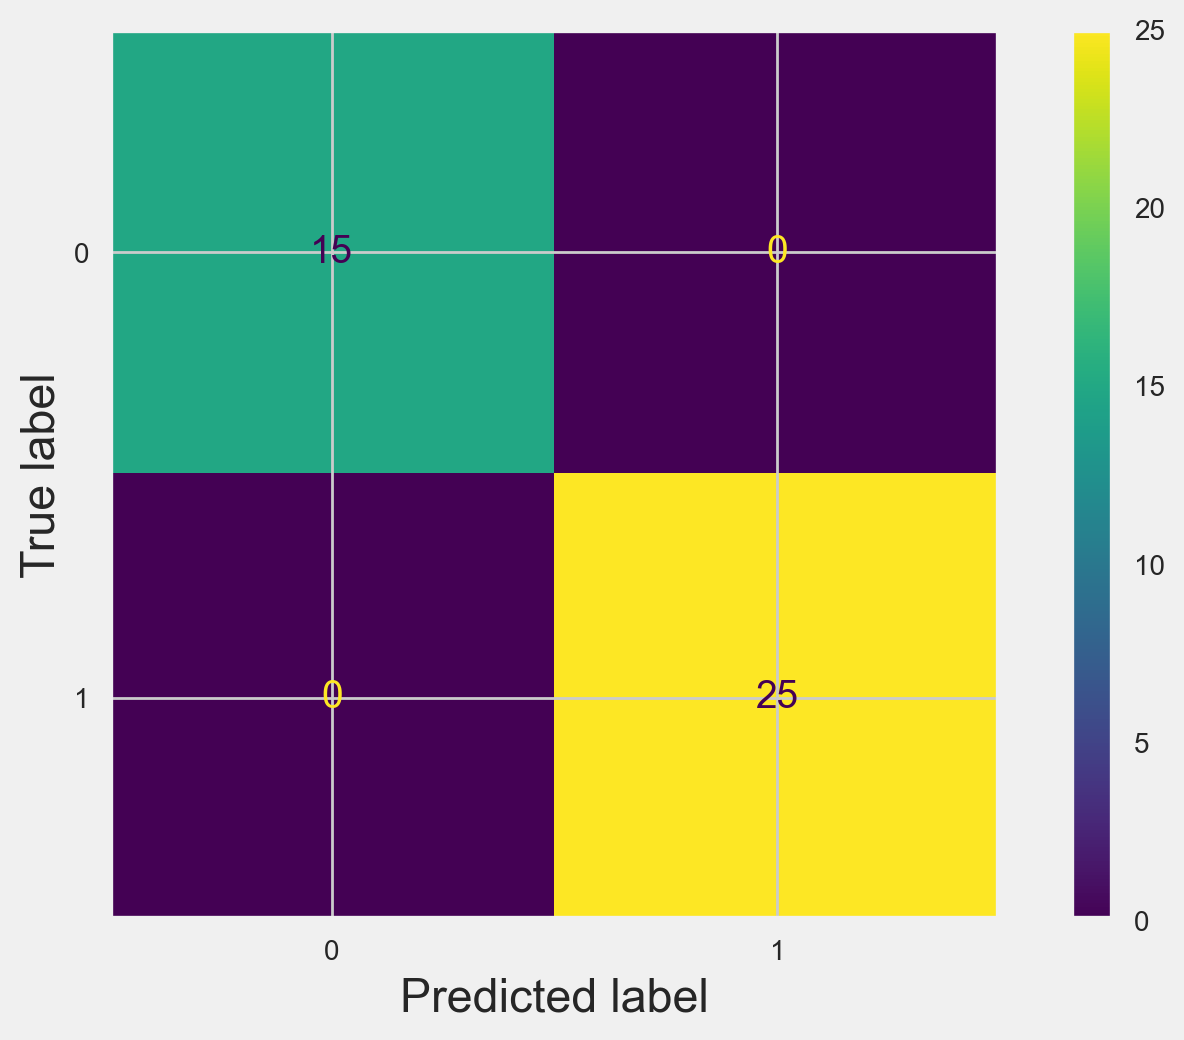

In [29]:
# Create predictions using X_test
pred = grid_simple.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_simple.classes_)
disp.plot();

In [30]:
# Get precision score
precision = precision_score(y_test, pred)
precision

1.0

In [31]:
# Get recall score
recall = recall_score(y_test, pred)
recall

1.0

In [32]:
# Get f1 score
f1_score(y_test, pred)

1.0

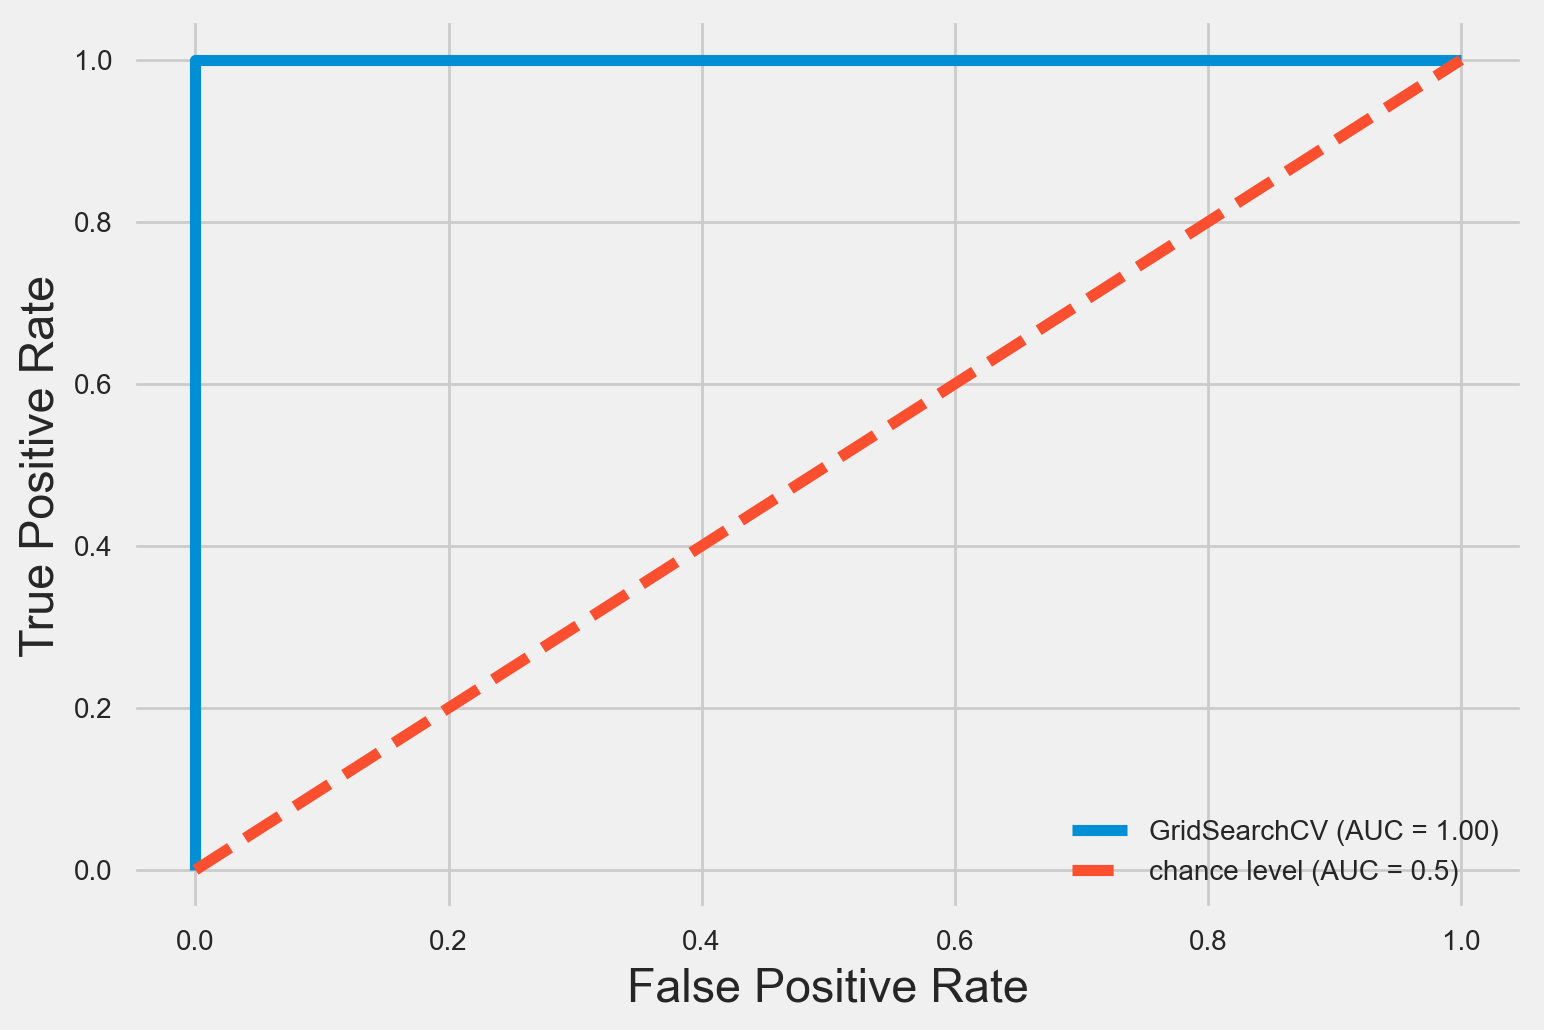

In [33]:
# Create the ROC curve
RocCurveDisplay.from_estimator(grid_simple, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

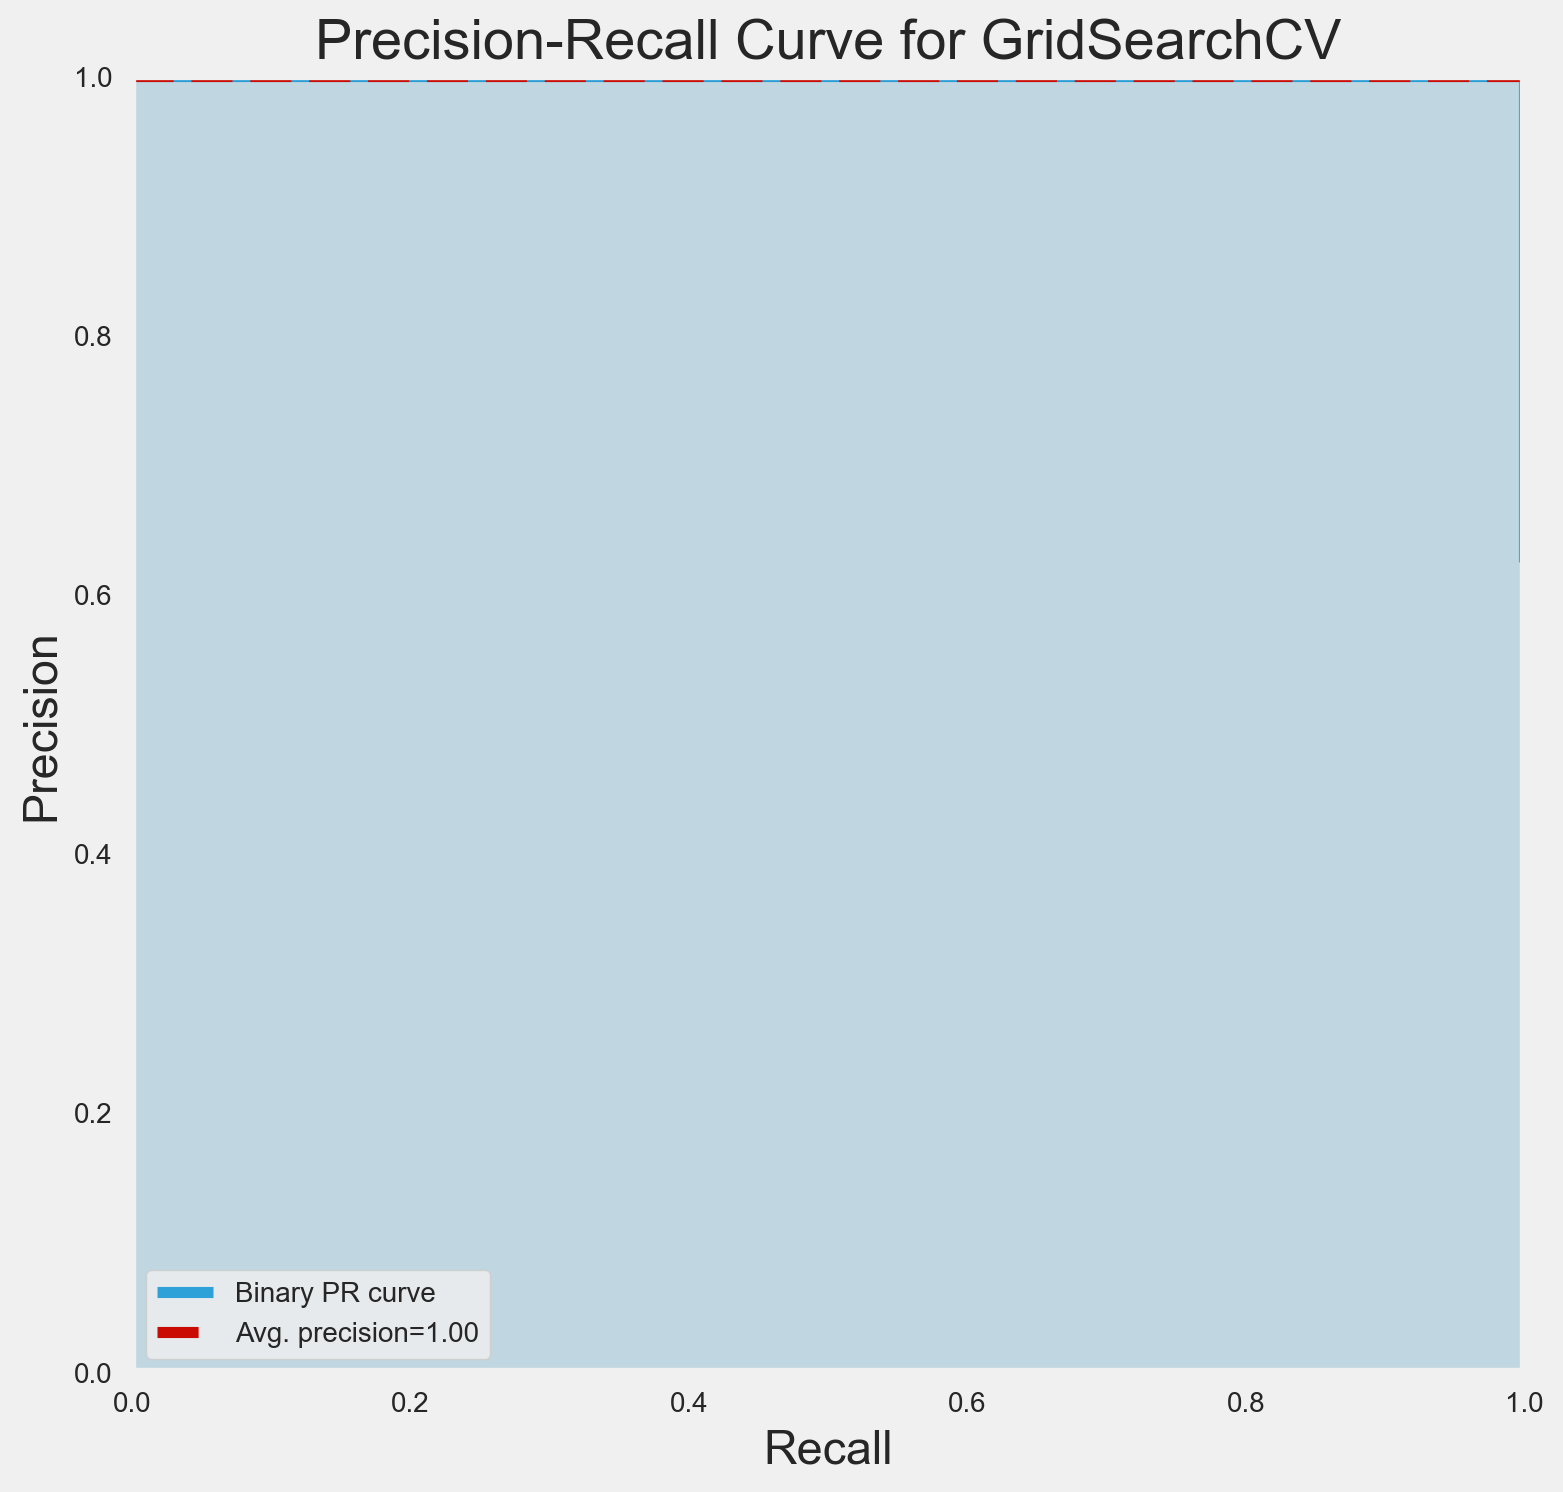

In [34]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(grid_simple)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

### Using IterativeImputer

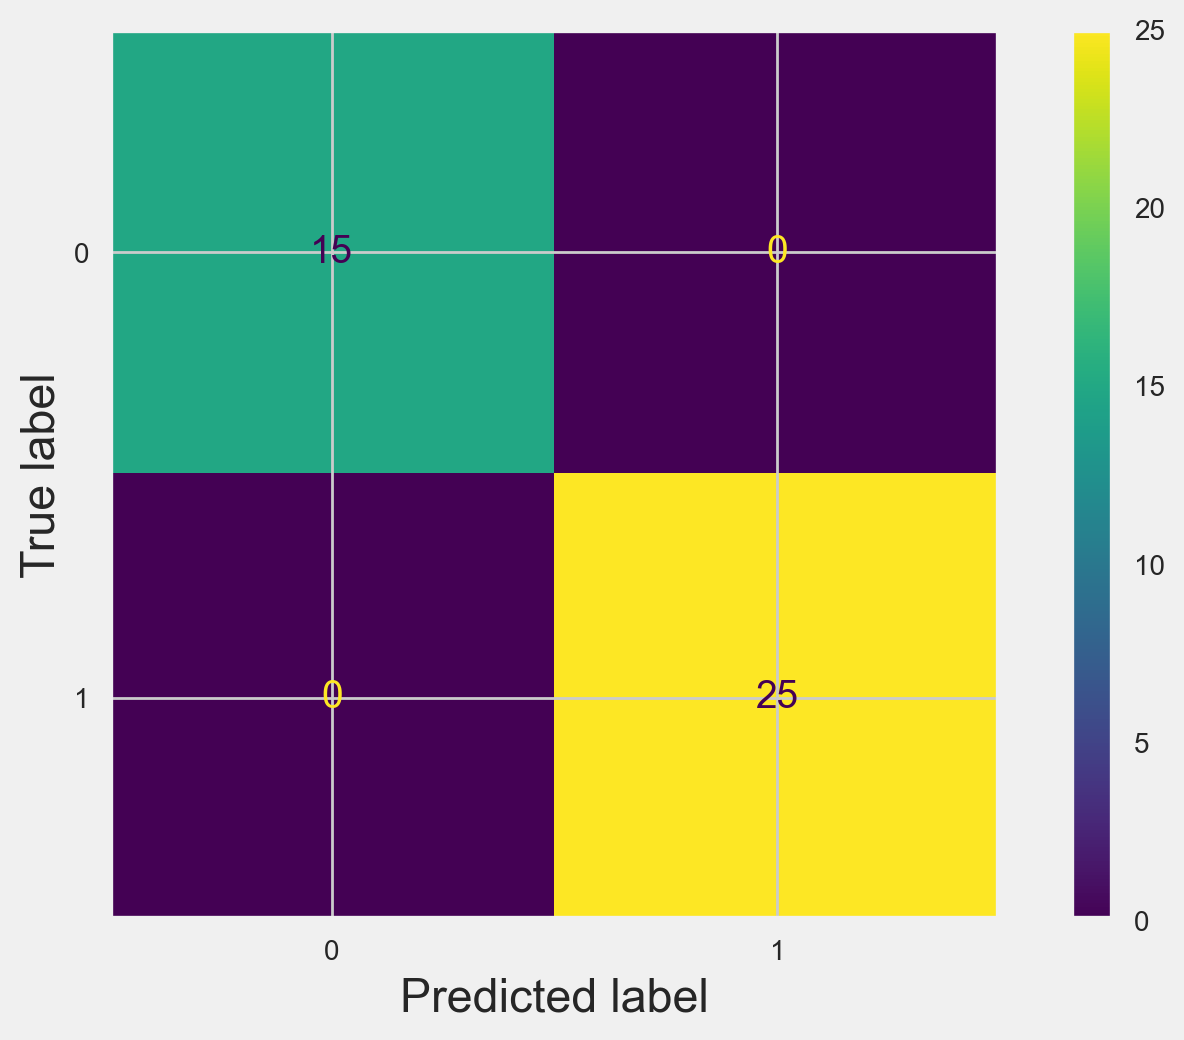

In [35]:
# Create predictions using X_test
pred = grid_iterative.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_iterative.classes_)
disp.plot();

In [36]:
# Get precision score
precision = precision_score(y_test, pred)
precision

1.0

In [37]:
# Get recall score
recall = recall_score(y_test, pred)
recall

1.0

In [38]:
# Get f1 score
f1_score(y_test, pred)

1.0

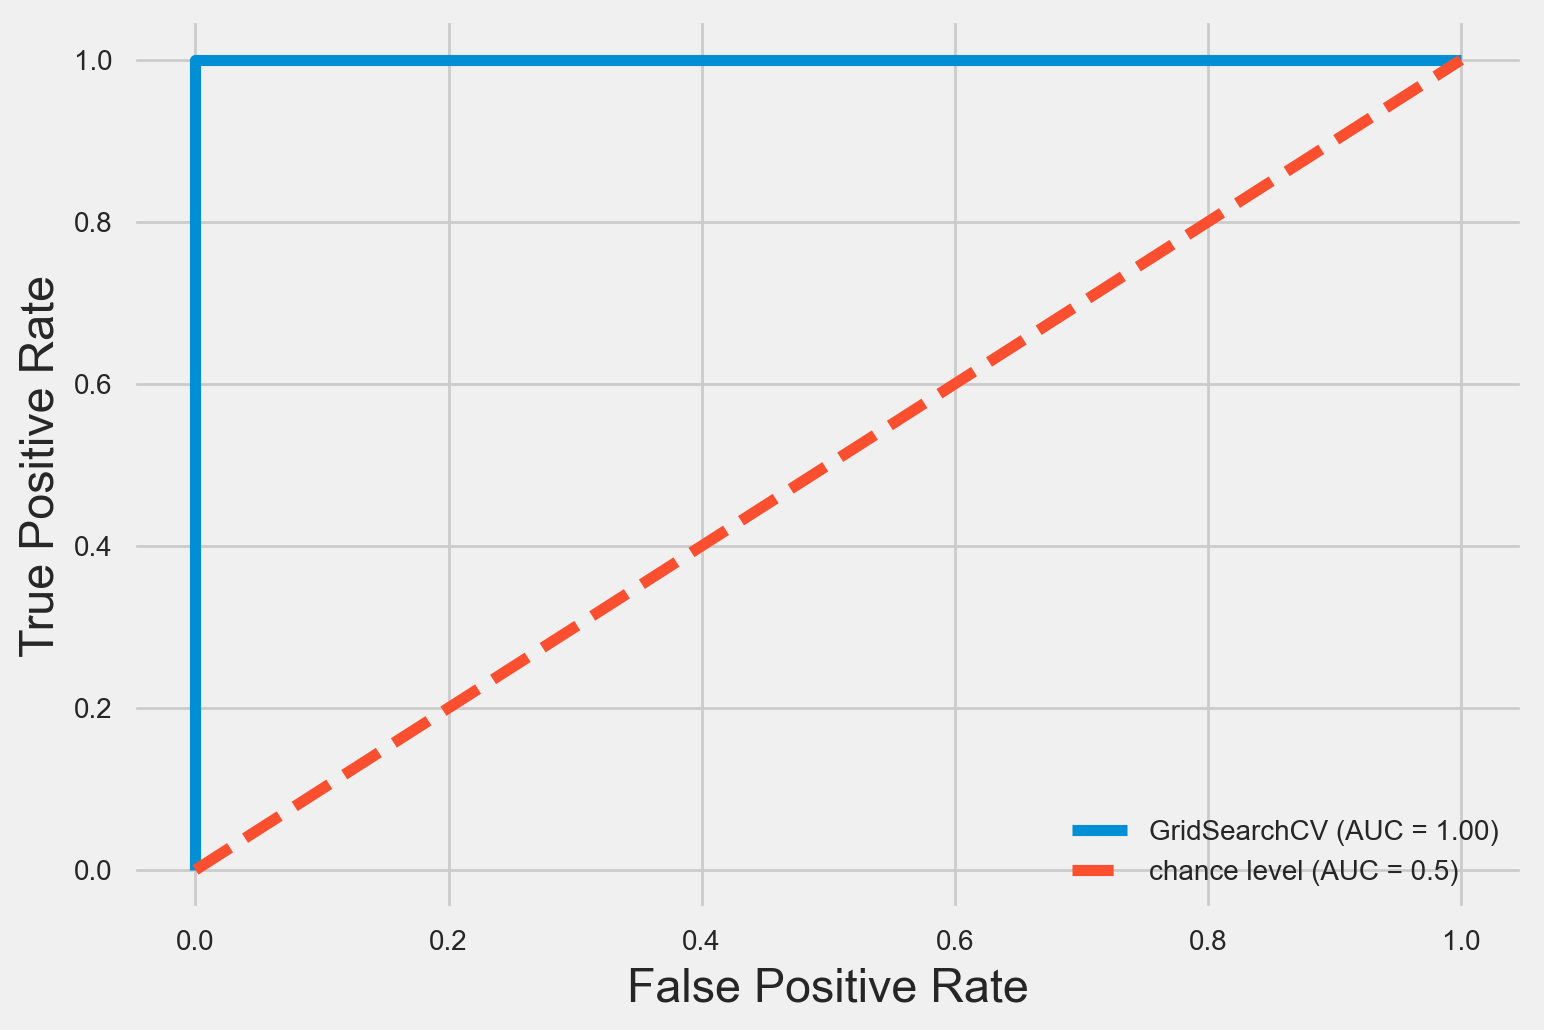

In [39]:
# Create the ROC curve
RocCurveDisplay.from_estimator(grid_iterative, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

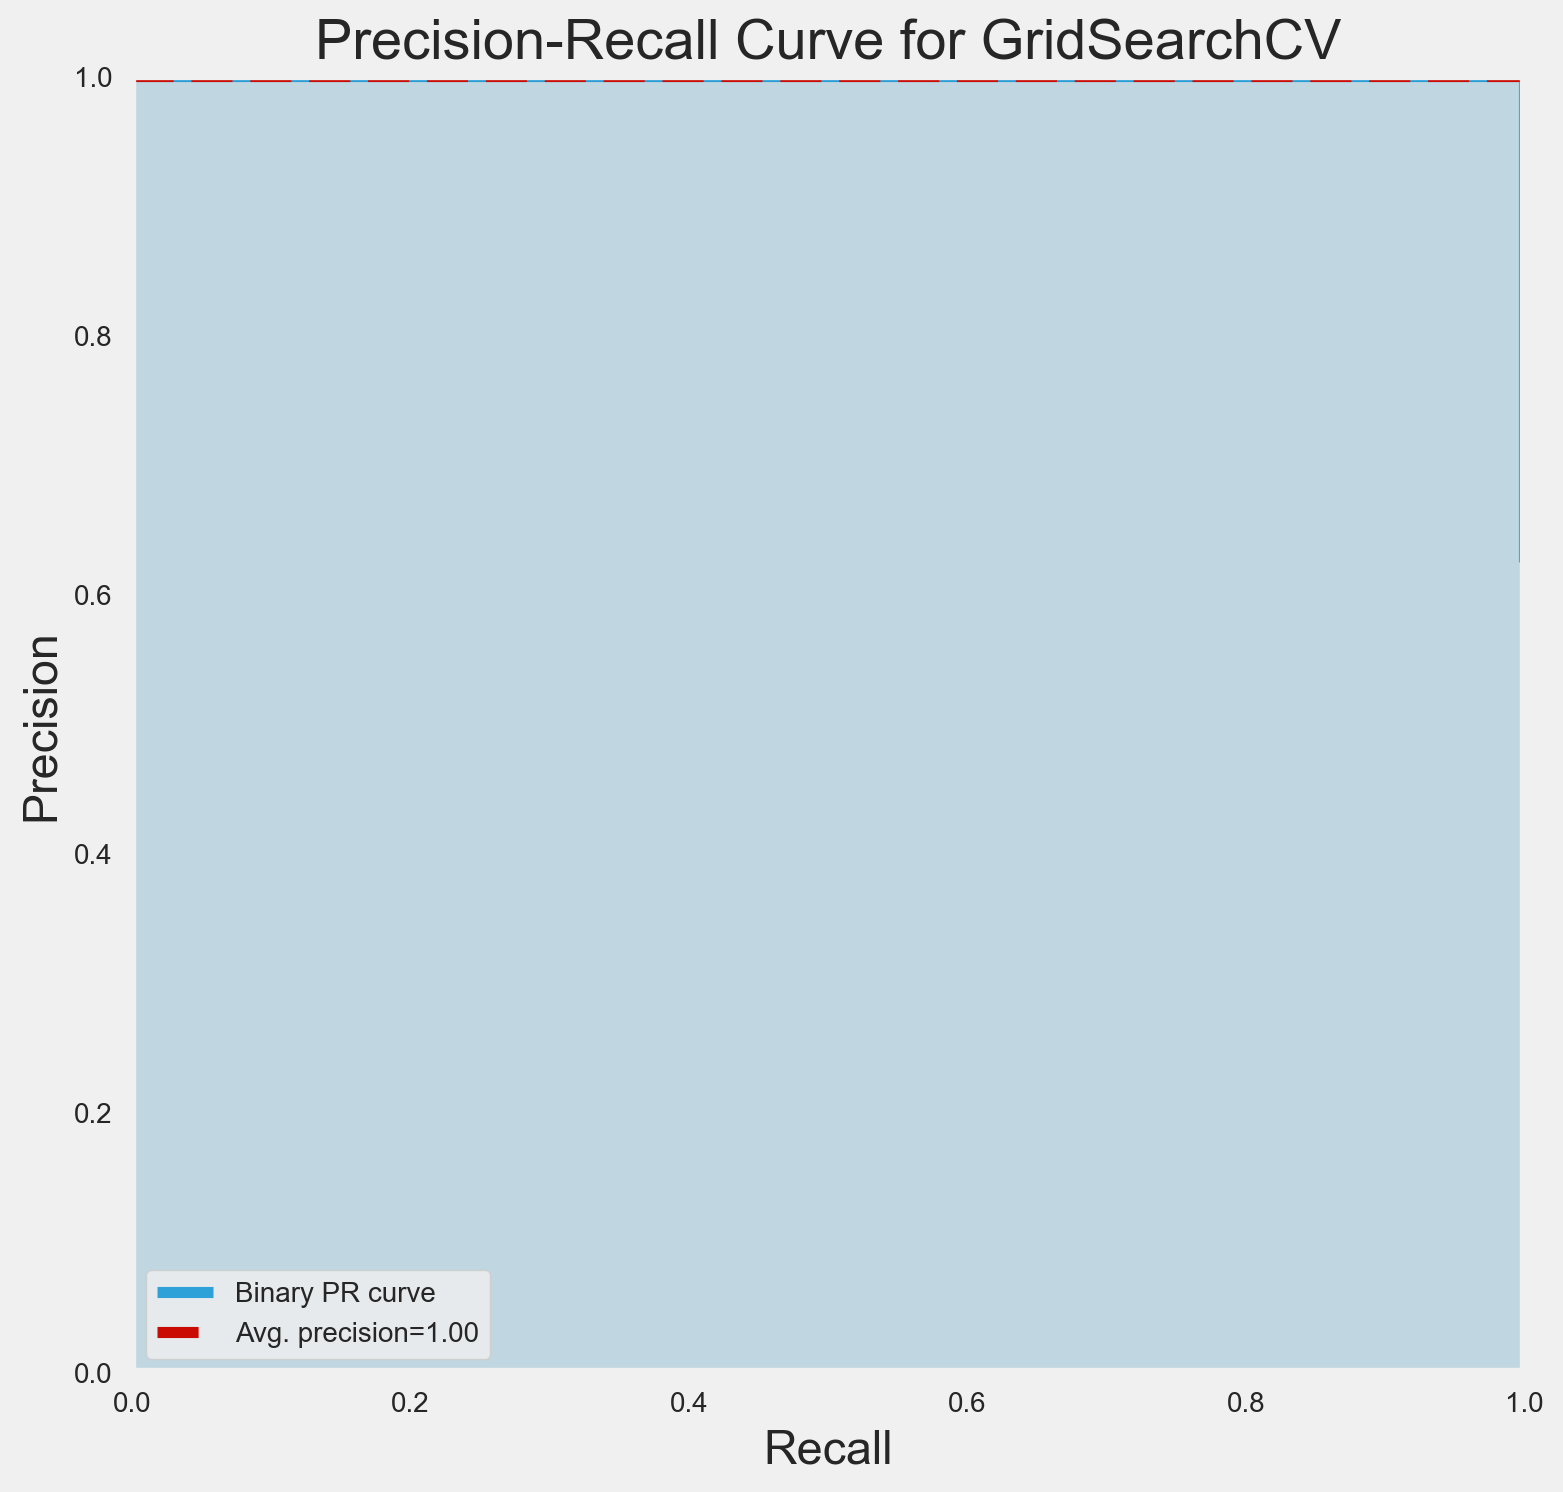

In [40]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(grid_iterative)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

### 6.1 Is there a balanced binary class between patient with CKD and patients without CKD?
Is it appropriate to use `accuracy score` to assess your model performance if your target variable is imbalance? Why?
> If not, what metric would you recommend to use?

**Answer**:

For an imbalanced class, I'm going to assume that the 'positive with ckd' is assigned to '1' and the 'negative with ckd' is assigned to '0' and that the majority class is class '1'. In this case, as we seen with the previous lab '04_01', the model can achieve a very high accuracy score simply by predicting the majority class only. The accuracy score will be the percentage of the majority class. This is rather misleading, as often we would like to make a correct prediction for the minority class. We can either use recall or precision, but there will be a trade off between the two. To give an example, if we are looking for ckd (and considering ckd to be the positive classification). To get high recall (identify all of the patients with ckd), we can just classify every patient as having ckd. But in a medical setting, this would not be ethical and would lead to a lot of complaints, unhappy patients and potential lawsuits, and this is ignoring all the unnecessary side effects from treating false positives. On the other hand, to get high precision (only catch ckd if it is ckd), we could have a model that only identifies cases of extreme ckd (very, very bad and terminal ckd). But this would miss much of the ckd that might not be as obvious and could lead to a lot of untreated patients. There will be a loss to society in not treating these patients. There is clearly a trade-off here. Now, since the requirement was to minimize both the false positives and false negatives, then we need to maximise both precision and recall. In this case, we should rank our models using the f1 score.


### 6.2 Comment on the model's performance using the metric score

Generate model train and test scores (f1 score, recall and precision).<br>
Generate confusion matrix display as well.

**Answer**:

From the plots above, I have generated the confusion matrix, precision-recall curve and ROC curve. For some reason, the model seems to be able to perfectly predict patients with and without ckd. Amazing! I'm beginning to suspect that this and the previous lab were previously chosen to give such stark and contrasting results..

### 6.3. Based on your logistic regression model constructed, interpret the coefficient your features.

In [41]:
# Create a list of logistic regression coefficients
coef_list = grid_simple.best_estimator_.named_steps.classifier.coef_.ravel()

In [42]:
# Create a list of coefficients with their respective names
coef_list_with_names = list(zip(X.columns, np.exp(coef_list)))

In [43]:
for i in coef_list_with_names:
    print(f'For the feature, {i[0]}, a change in one unit, means the person is {i[1]} times as likely to get ckd')

For the feature, age, a change in one unit, means the person is 0.747381330096852 times as likely to get ckd
For the feature, bp, a change in one unit, means the person is 1.4085769040816363 times as likely to get ckd
For the feature, sg, a change in one unit, means the person is 0.280739752828327 times as likely to get ckd
For the feature, al, a change in one unit, means the person is 3.580090286264655 times as likely to get ckd
For the feature, su, a change in one unit, means the person is 1.410869949933993 times as likely to get ckd
For the feature, rbc, a change in one unit, means the person is 2.046959642246471 times as likely to get ckd
For the feature, pc, a change in one unit, means the person is 0.9042261744649229 times as likely to get ckd
For the feature, pcc, a change in one unit, means the person is 1.9477284484295594 times as likely to get ckd
For the feature, ba, a change in one unit, means the person is 0.6011038429657001 times as likely to get ckd
For the feature, bgr,

### 6.4. Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. We want to look at all values of your "threshold"
    - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." 
    - Start the threshold at 0.
1. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
1. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
1. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
1. Repeat the above steps until you get to the threshold of 1.
1. Plot the values of sensitivity and 1 - specificity.

In [44]:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas,
    true is a pandas series of true labels,
    step is the step size for checking thresholds
    """
    # Slice for all rows of probabilities for class 1
    probas = probas[:,1]
    # Convert the class labels from a Pandas Series to a numpy array using .values 
    true = true.values
    # Assert that the probabilities vector is the same length as the true class labels vector
    assert(len(probas) == len(true)) 

    # Creating empty list for True Positive Rate
    TPRs = [] 
    # Creating empty list for False Positive Rate
    FPRs = [] 
    
    for i in np.arange(0.0, 1.0, step): 
        preds_class = probas > i
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        # Compare each prediction with each true value 
        for index in range(len(preds_class)): 
            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
        # Calculating TPR and FPR and append to respective lists       
        TPR = TP/(TP + FN)
        FPR = FP/(FP + TN)     
        TPRs.append(TPR)
        FPRs.append(FPR)

    # Plot the ROC
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

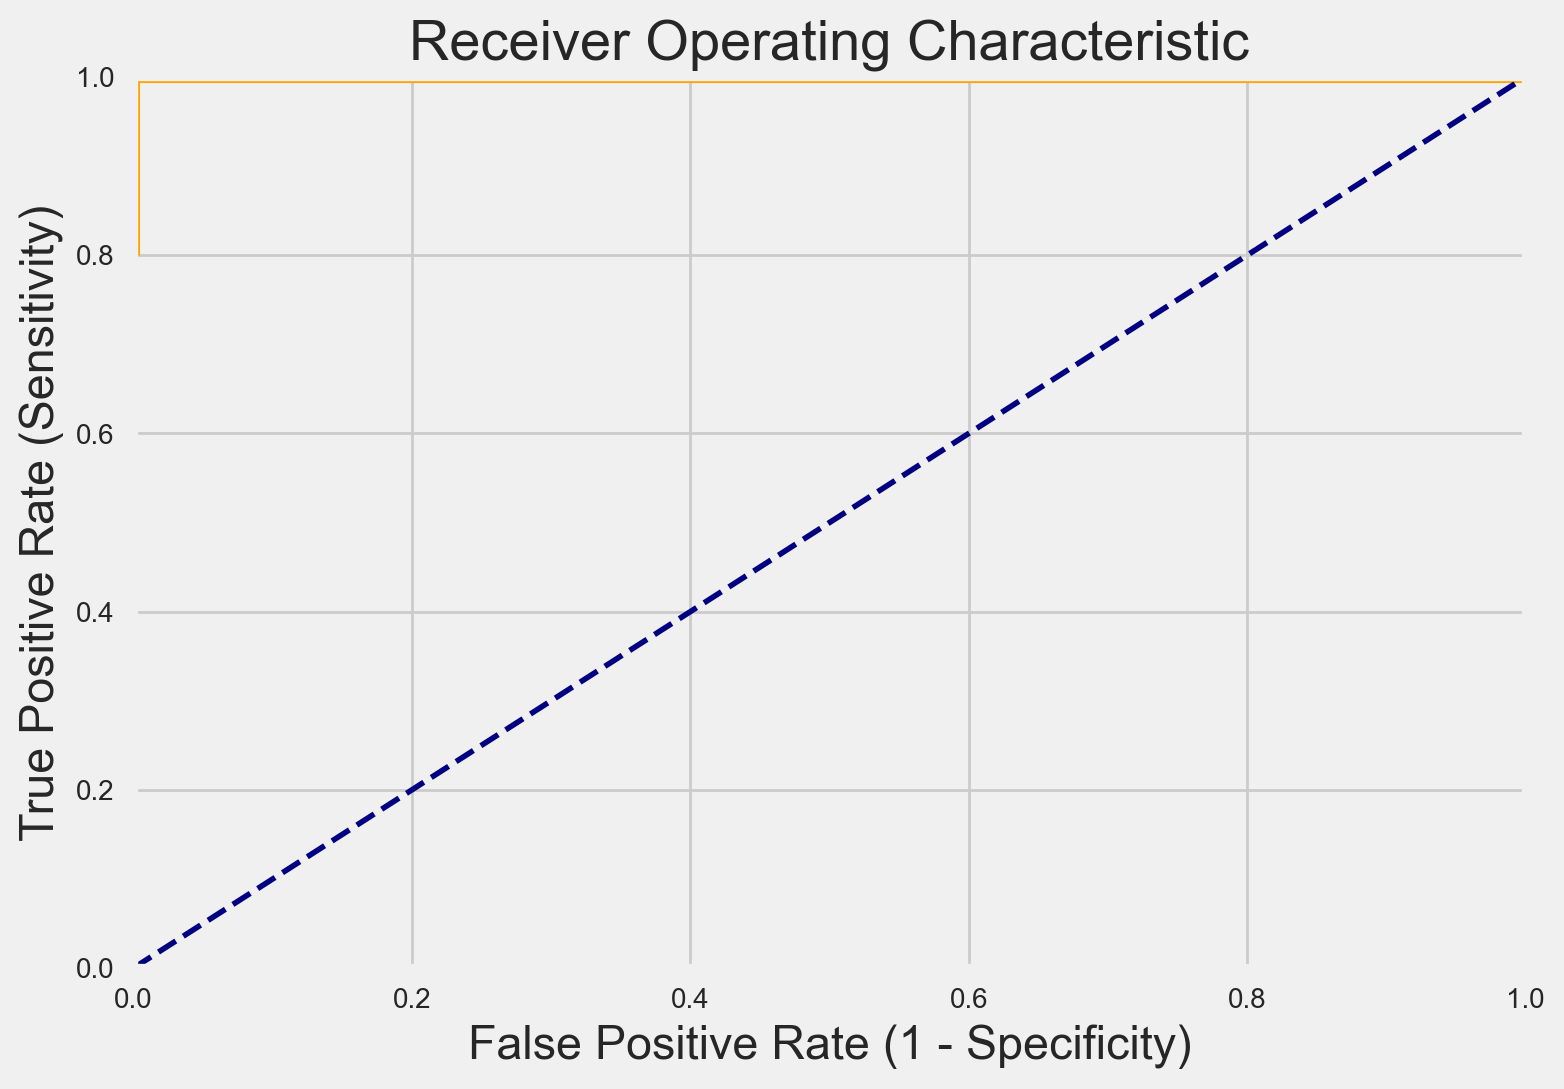

In [45]:
# Predict probabilities for our test set
probabilities = grid_simple.predict_proba(X_test)
# Create ROC curve
roc(probas=probabilities, true=y_test);            

## Step 7. Using a very unbalanced dataset

### 7.1 Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD with replacement. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

Note: You may have fewer than 200,000 observations if you chose to drop missing values above!

In [46]:
# Combining X_train and y_train into one dataframe for resampling
training_set = pd.concat([X_train, y_train], axis=1) 
# Create a dataframe with rows where the respondent has ckd
ckd = training_set[training_set['class']==1]
# Create a dataframe with rows where the respondent has no ckd
no_ckd = training_set[training_set['class']==0]
# Resample our majority class with replacement up to 200,000 rows
oversample = resample(ckd, replace=True, n_samples=200000, random_state=123) 

In [47]:
# Concatenate resampled dataframe and minority class dataframe
oversample_train = pd.concat([no_ckd, oversample])
# Assign our features matrix to X_train 
X_train = oversample_train.drop('class', axis=1)
# Assign our target matrix to y_train
y_train = oversample_train['class']
# Check for class imbalance, we did it
y_train.value_counts(normalize=True)

class
1    0.999325
0    0.000675
Name: proportion, dtype: float64

### 7.2 Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. 

In [48]:
# The logic for this code cell is the same as under the SimpleImputer header
numeric_features = list(ckd.select_dtypes('float').columns)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()),
           ("scaler", StandardScaler())
          ]
)

categorical_features = list(ckd.select_dtypes('object').columns)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipe_iterative_unbalanced = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)


In [49]:
# Create a list of parameters to pass into our GridSearchCV object
parameters = {'classifier__C': [0.1, 10],
              'classifier__solver':['liblinear'],
              'classifier__class_weight': ['balanced'],
              'classifier__penalty': ['l1']}

# Pass our pipeline object into GridSearchCV with our chosen parameter list and then fit the logistic regression estimator to the train data
grid_iterative_unbalanced = GridSearchCV(pipe_iterative_unbalanced, param_grid = parameters, scoring = 'f1', cv = 3).fit(X_train, y_train)

In [50]:
# Print out the best estimator
grid_iterative_unbalanced.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bp', 'sg', 'al',
                                                   'su', 'bgr', 'bu', 'sc',
                                                   'sod', 'pot', 'hemo', 'pcv',
                                                   'wbcc', 'rbcc']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'htn', 'dm', 'cad', 'appet',
                                                   'pe', 'ane'])])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])

In [51]:
# Print out the best parameters
grid_iterative_unbalanced.best_params_

{'classifier__C': 0.1,
 'classifier__class_weight': 'balanced',
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [52]:
# Print out the best score
grid_iterative_unbalanced.best_score_

0.999990000199996

In [53]:
# Score our logistic regressor on the test set
grid_iterative_unbalanced.score(X_test, y_test)

1.0

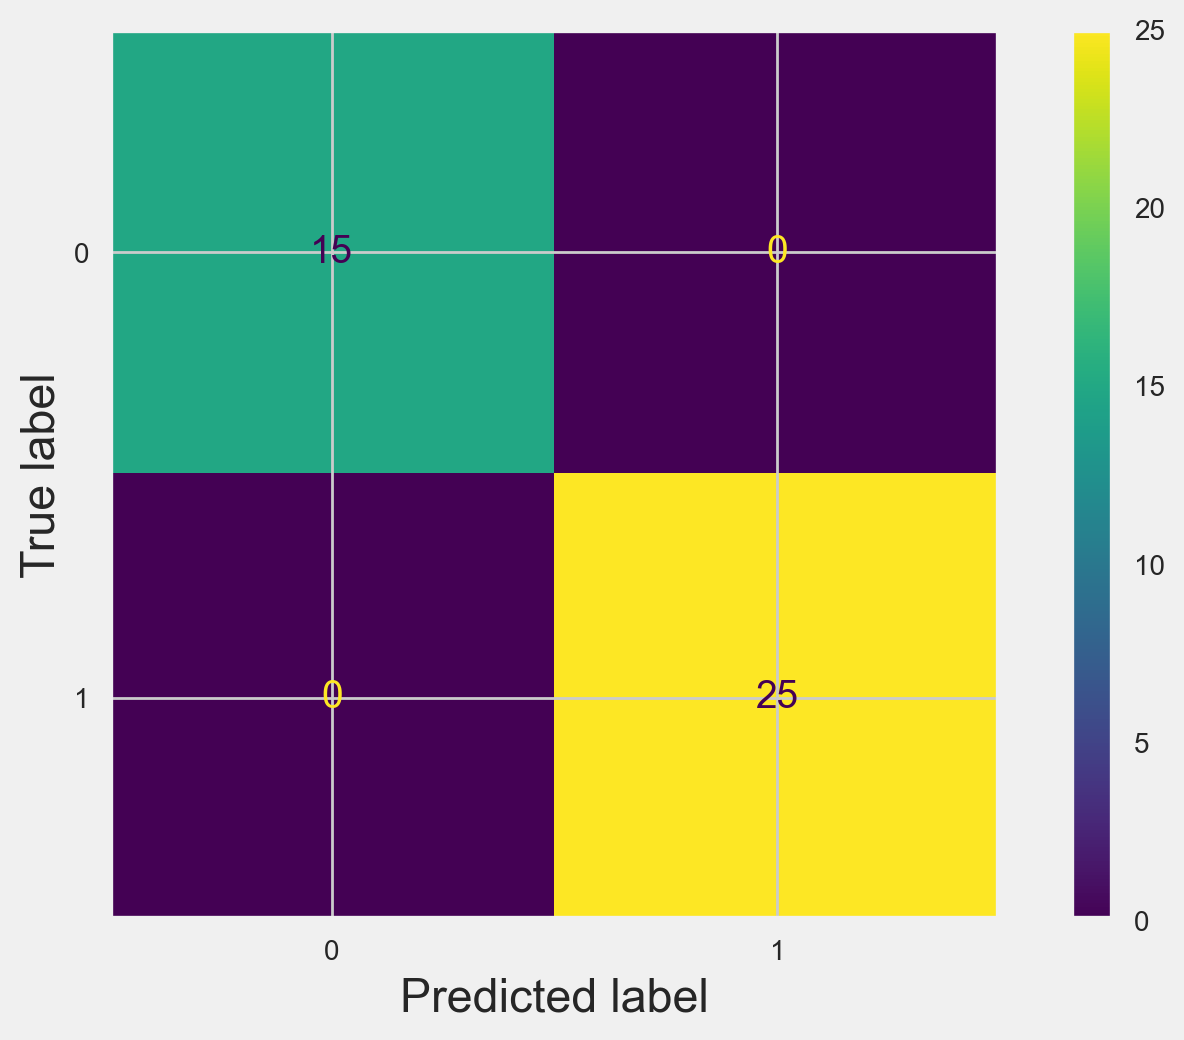

In [54]:
# Create predictions using X_test
pred = grid_iterative_unbalanced.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_iterative_unbalanced.classes_)
disp.plot();

In [55]:
# Get precision score
precision = precision_score(y_test, pred)
precision

1.0

In [56]:
# Get recall score
recall = recall_score(y_test, pred)
recall

1.0

In [57]:
# Get f1 score
f1_score(y_test, pred)

1.0

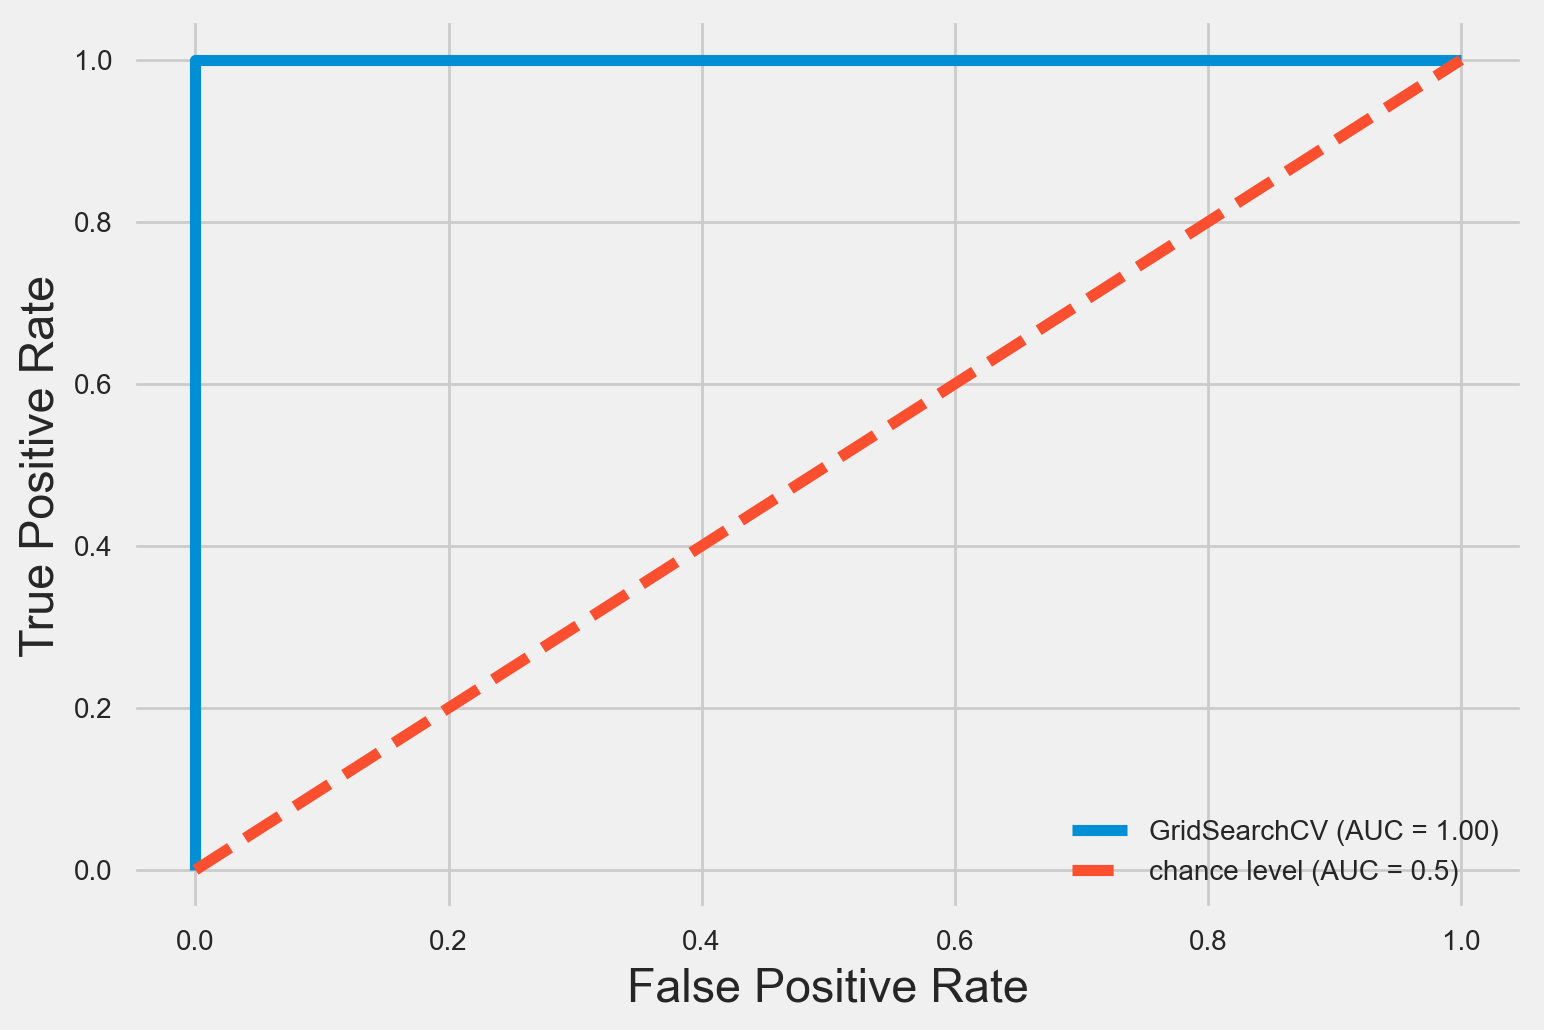

In [58]:
# Create the ROC curve
RocCurveDisplay.from_estimator(grid_iterative_unbalanced, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

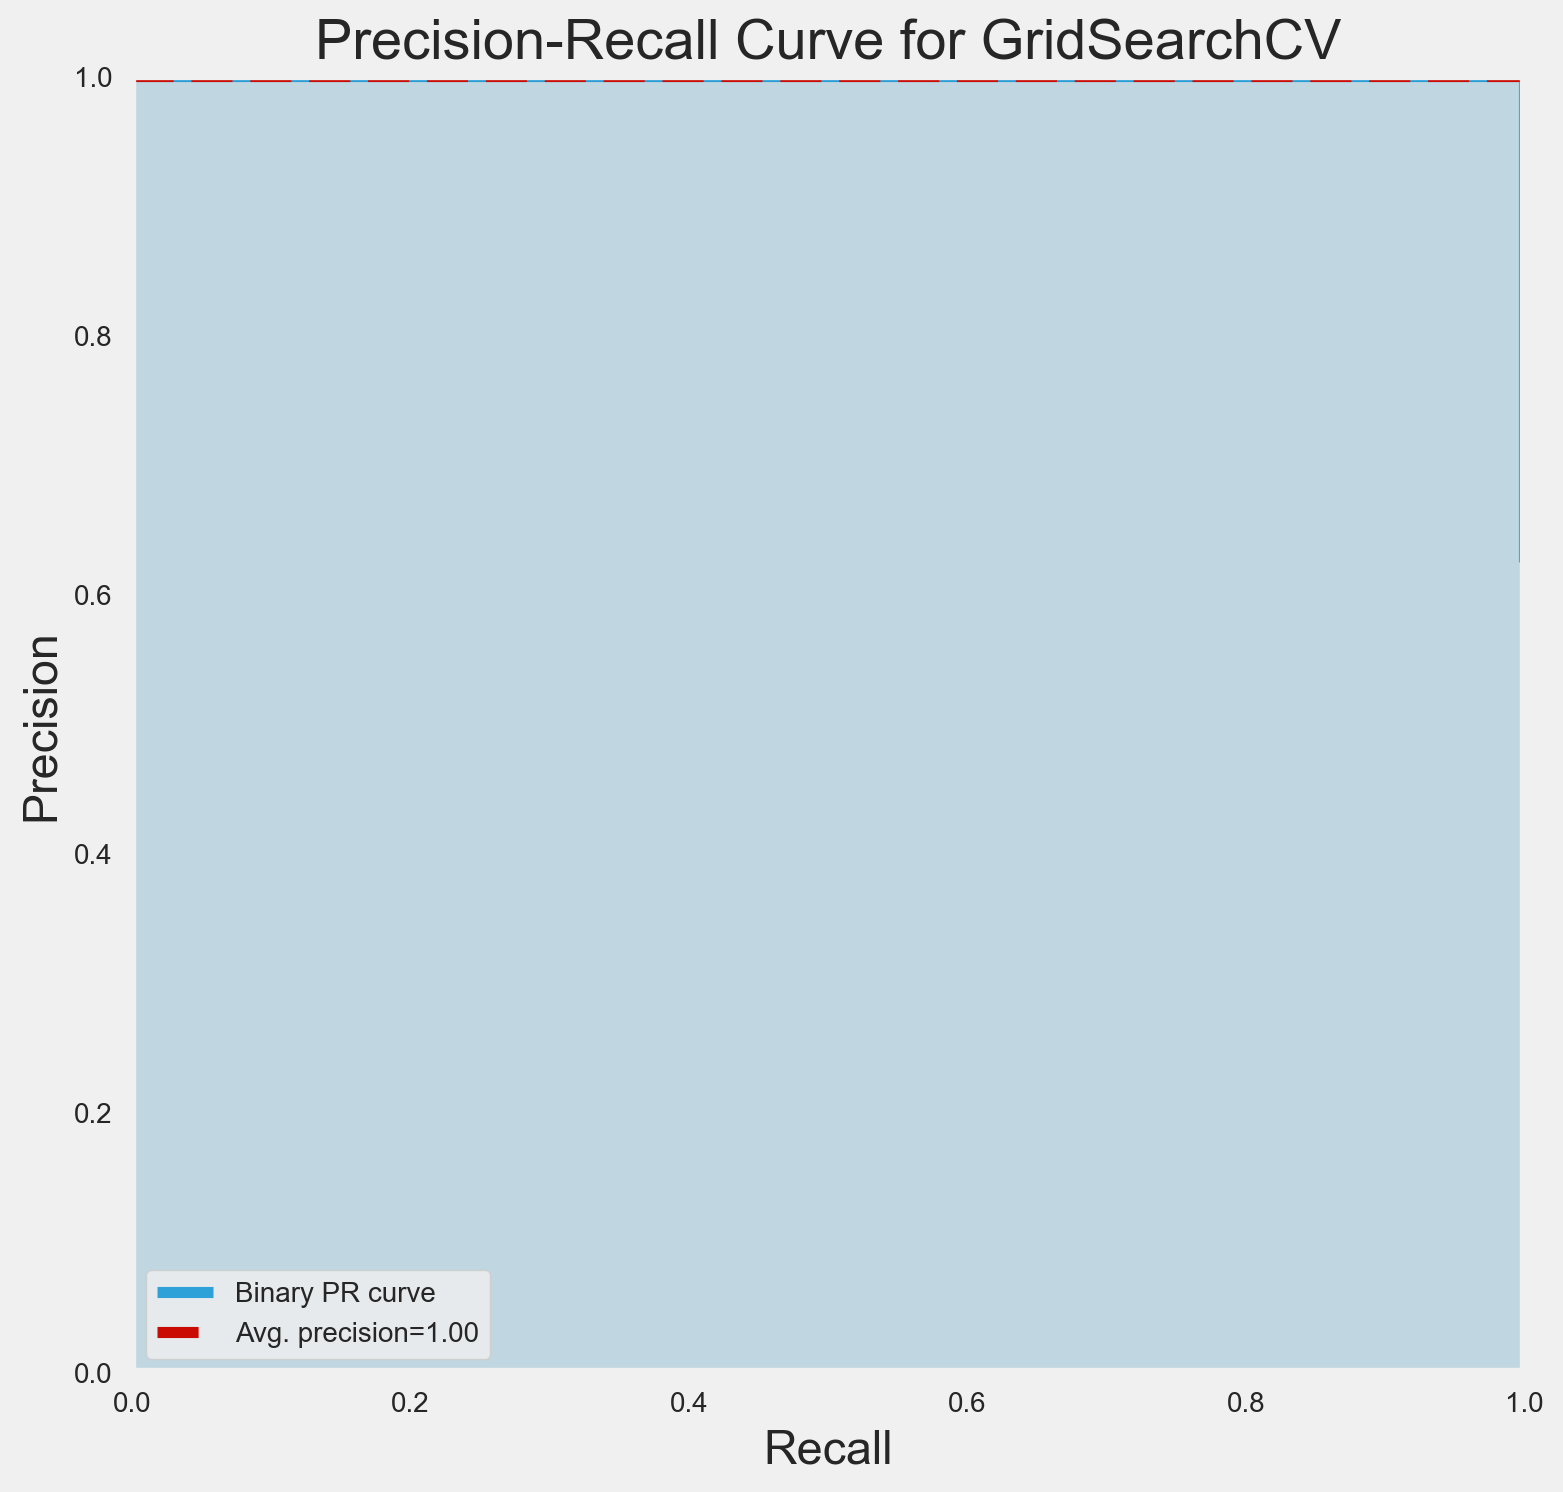

In [59]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(grid_iterative_unbalanced)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

Answer:

- Since we would like to minimize false negatives and false positives, we should compare not just on recall and precision scores but also on the f1 score.
- In this case, the sensitivity score for the model is 100%. This is true even before we resampled the majority class. We have created a perfect classifier, at least for predicting ckd or not using the features in this case study.


### 7.3 How would you describe the impact of unbalanced classes on logistic regression as a classifier?

**Answer:** 

- Unbalanced classes are generally a problem because the minority class is at risk of not having enough exposure during the modelling process to be accounted for in the model. In other words, since there is so little of the minority class(es), the model cannot sufficiently pick up its signal, resulting in its attributes being overlooked/missed during the prediction process.
- As an example, let's say that we treat a patient who comes in with a broken arm. These things happen pretty frequently, so we have a good idea of how to fix it, what potential complications are, etc. On the other hand, let's say we treat a patient who presents with odd symptoms that we have never seen before. We check books and do research, but it's very hard to understand this disease becauses we just don't have enough information to identify causes or recommend treatments.
- That is the problem of unbalanced classes. When we build a model where we have lots of broken arms but very few "rare diseases," it's hard for our model to learn about those rare diseases because we see them so infrequently that we don't have enough information.
